# Stock Predictor Model

### Necessary imports

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

### Loading dataset

In [4]:
df = pd.read_csv('stock-predictor-dataset.csv')

print(df.head())

         date       open       high        low      close   adjclose  volume  \
0  2022-01-03  17.799999  18.219000  17.500000  17.760000  17.760000  106600   
1  2022-01-04  17.700001  18.309999  17.620001  17.660000  17.660000  128700   
2  2022-01-05  17.580000  17.799999  16.910000  16.950001  16.950001  103100   
3  2022-01-06  16.650000  16.879999  16.139999  16.170000  16.170000  173600   
4  2022-01-07  16.219999  16.290001  15.630000  15.710000  15.710000  137800   

  ticker  RSIadjclose15  RSIvolume15  ...  high-15  K-15  D-15  \
0   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
1   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
2   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
3   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
4   ASLE            NaN          NaN  ...      NaN   NaN   NaN   

   stochastic-k-15  stochastic-d-15  stochastic-kd-15  volumenrelativo  \
0              NaN              NaN             

### Cleaning the dataset and visualizing the closing prices 

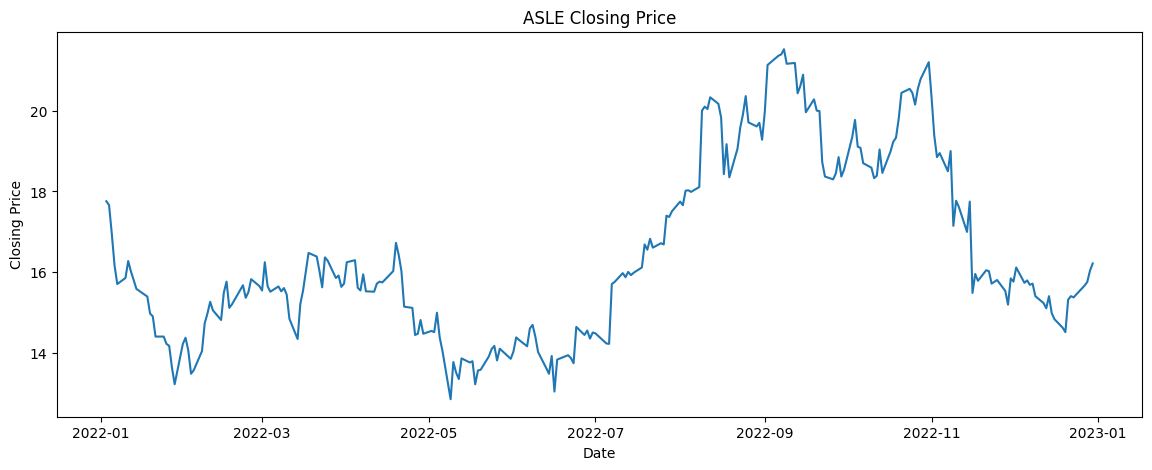

date     0
close    0
dtype: int64


<ipython-input-18-8a5a81a97c59>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_single_ticker.fillna(method='ffill', inplace=True)


In [18]:
ticker = 'ASLE' ## Selecting a ticker for the dataset
df_single_ticker = df[df['ticker'] == ticker].copy()

# Drop unnecessary columns
df_single_ticker = df_single_ticker[['date', 'close']]

# Convert date to datetime
df_single_ticker['date'] = pd.to_datetime(df_single_ticker['date'])

# Sort by date
df_single_ticker = df_single_ticker.sort_values('date')

# Reset index
df_single_ticker = df_single_ticker.reset_index(drop=True)

# Plot the closing price
plt.figure(figsize=(14, 5))
plt.plot(df_single_ticker['date'], df_single_ticker['close'])
plt.title(f'{ticker} Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Check for missing values
print(df_single_ticker.isna().sum())

# Fill missing values if any (using forward fill method)
df_single_ticker.fillna(method='ffill', inplace=True)


**From the graph above, we can see the following:**

* The stock price fluctuaties between about $13 and $22 throughout the year
* The stock seems volatile, there is no clear upward or downward trend 
  
**What does this mean for our model ?**

* The high volatility suggests that prediction might be challenging and ideally the model should be able to handle rapid price changes 



#### Plotting the moving averages

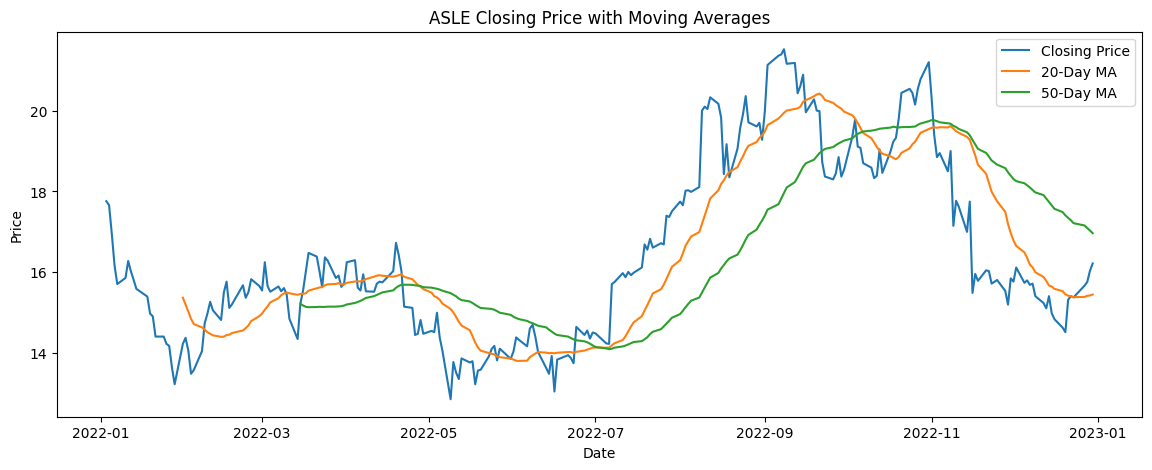

In [23]:
# Calculate moving averages
df_single_ticker['MA20'] = df_single_ticker['close'].rolling(window=20).mean()
df_single_ticker['MA50'] = df_single_ticker['close'].rolling(window=50).mean()

# Plot moving averages
plt.figure(figsize=(14, 5))
plt.plot(df_single_ticker['date'], df_single_ticker['close'], label='Closing Price')
plt.plot(df_single_ticker['date'], df_single_ticker['MA20'], label='20-Day MA')
plt.plot(df_single_ticker['date'], df_single_ticker['MA50'], label='50-Day MA')
plt.title(f'{ticker} Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


**What is Moving Average?**

It is a stock indicator that is used in technical analysis. It helps to level the price data over a period by creating a constantly updated average price of the stock. 

**Short Term Trend v/s Long Term Trend:**

The 20 day MA (the orange line) responds more quickly to price changes, while the 50 day MA shows long term trends

**Buy/Sell Signals:**

There are several points where moving averages cross each other (which often help traders use as buy / sell signals) : 
    * Early July: 20 day MA crosses above 50 day MA (bull trend)
    * Late October: 20 day MA crosses below the 50 day MA (bearish trend)



### Plotting the daily returns

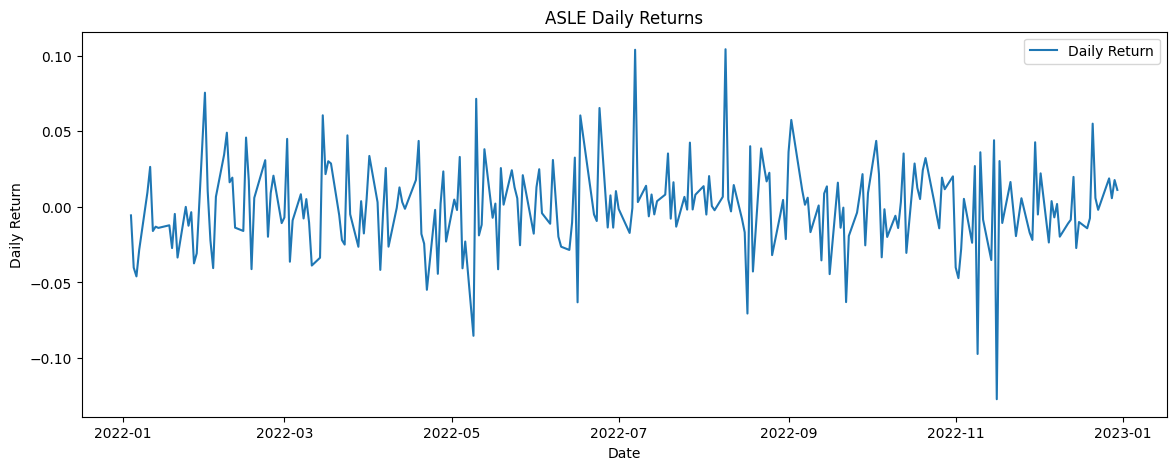

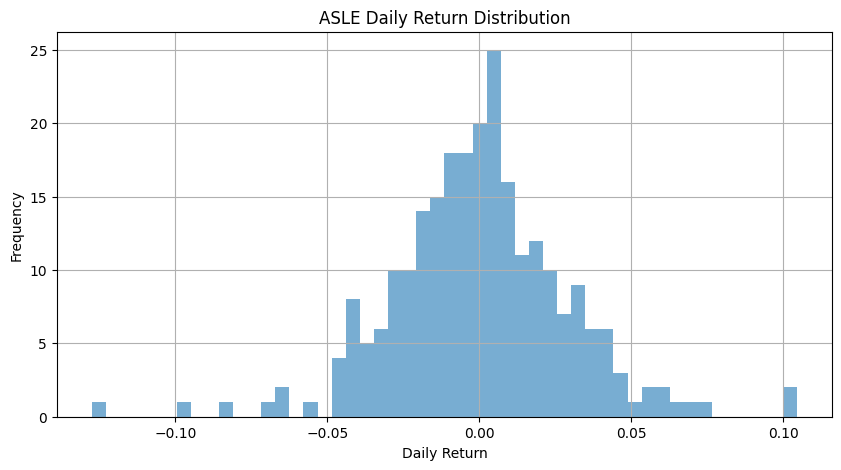

In [21]:
# Calculate daily returns
df_single_ticker['Daily Return'] = df_single_ticker['close'].pct_change()

# Plot daily returns
plt.figure(figsize=(14, 5))
plt.plot(df_single_ticker['date'], df_single_ticker['Daily Return'], label='Daily Return')
plt.title(f'{ticker} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
df_single_ticker['Daily Return'].hist(bins=50, alpha=0.6)
plt.title(f'{ticker} Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()



From the graphs above, we can infer the following : 

**Daily Returns (Time Series):**

* Stock shows significant daily volatility (between -10% and +10%)
* There are a couple of spikes in both positive and negative directions, with large price movements 
* Mean Reversion: Returns oscillate around 0, a mean-reverting tendency in the short term 

**Daily Return Distribution:**

* The peak of the distribution is slightly to the right of 0, suggesting a small positive average daily return 
* Fat tails: Indicates higher probability of extreme events than would be expected in a normal distribution. 



#### Print out basic statistics



In [22]:
# Summary statistics
summary_stats = df_single_ticker.describe()
print(summary_stats)

                                date       close  Daily Return
count                            251  251.000000    250.000000
mean   2022-07-02 15:23:39.920318720   16.460359      0.000064
min              2022-01-03 00:00:00   12.860000     -0.127324
25%              2022-04-02 12:00:00   14.780000     -0.016825
50%              2022-07-05 00:00:00   15.790000     -0.000673
75%              2022-10-01 12:00:00   18.340000      0.016426
max              2022-12-30 00:00:00   21.520000      0.104362
std                              NaN    2.190521      0.029204


## Building the model

#### Preprocessing Data

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the closing prices
scaler = MinMaxScaler(feature_range=(0, 1))
df_single_ticker['scaled_close'] = scaler.fit_transform(df_single_ticker[['close']])

# Prepare sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
sequence_length = 60

# Create sequences
X, y = create_sequences(df_single_ticker['scaled_close'].values, sequence_length)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')


Train shape: (133, 60), (133,)
Validation shape: (29, 60), (29,)
Test shape: (29, 60), (29,)


#### Building the LSTM model

In [25]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.1884 - val_loss: 0.0484
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0280 - val_loss: 0.1152
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0326 - val_loss: 0.0263
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0178 - val_loss: 0.0430
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0248 - val_loss: 0.0257
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0138 - val_loss: 0.0407
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0149 - val_loss: 0.0319
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0121 - val_loss: 0.0242
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0118 - val_loss: 0.0242
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0103 - val_loss: 0.0259
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0089 - val_loss: 0.0280
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0101 - val_loss: 0.0240


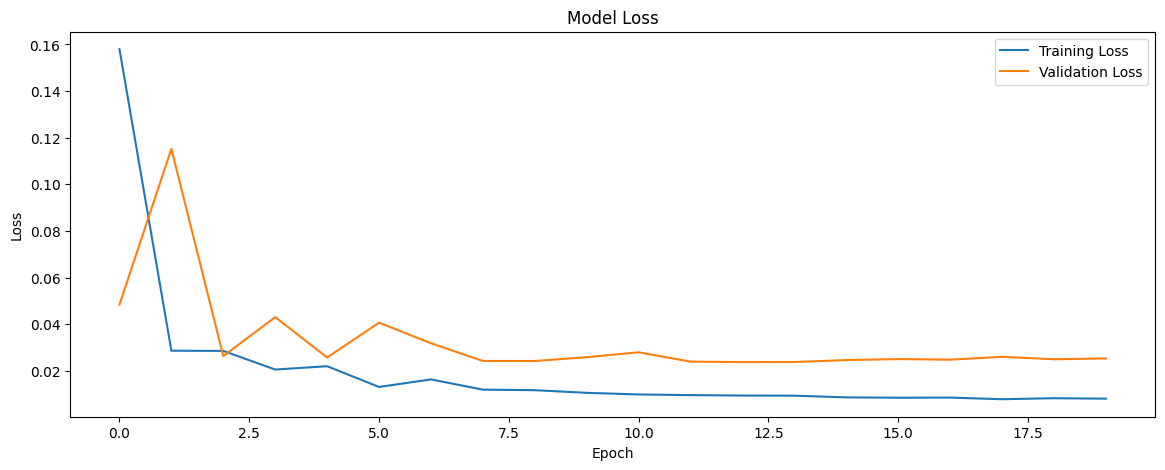

In [26]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


From the above Model Loss Graph, we can say the following : 

* Initial High Loss: Both training and validation losses start high (which indicates a poor performance)
* Rapid Improvement: Sharp decrease in both losses with the first few epochs, which shows that the model is learning quickly 
* The training loss (the blue line) remains below the validation loss (the orange line) which is expected behaviour. 



## Evaluating Model Performance

#### Predictions

In [27]:
# Make predictions on validation data
val_predictions = model.predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions)  # Convert back to original scale

# Make predictions on test data
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)  # Convert back to original scale


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


#### Evaluate Performance and plotting the results

Validation MSE: 1.8984867530015404
Validation MAE: 1.2452010779545224
Test MSE: 0.5143844567207358
Test MAE: 0.6042056576959018


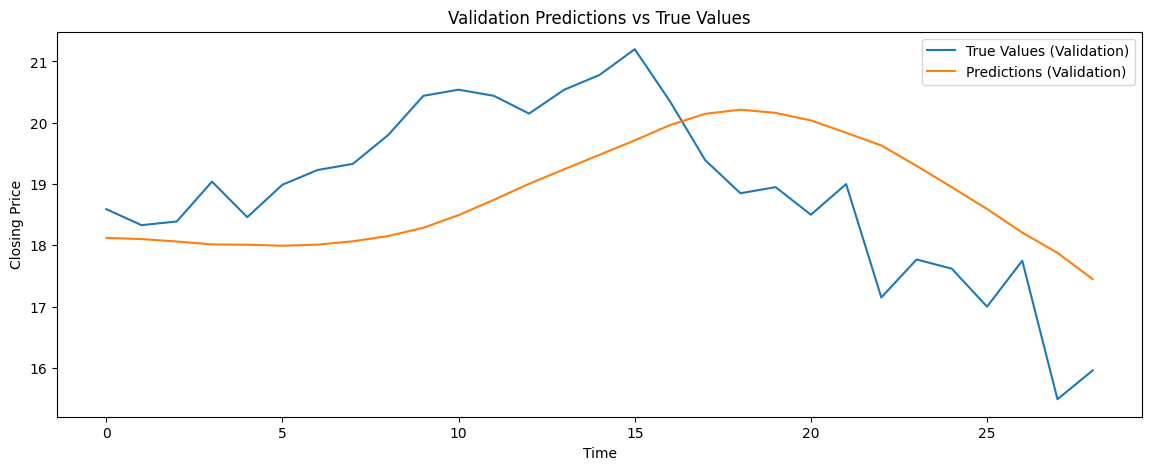

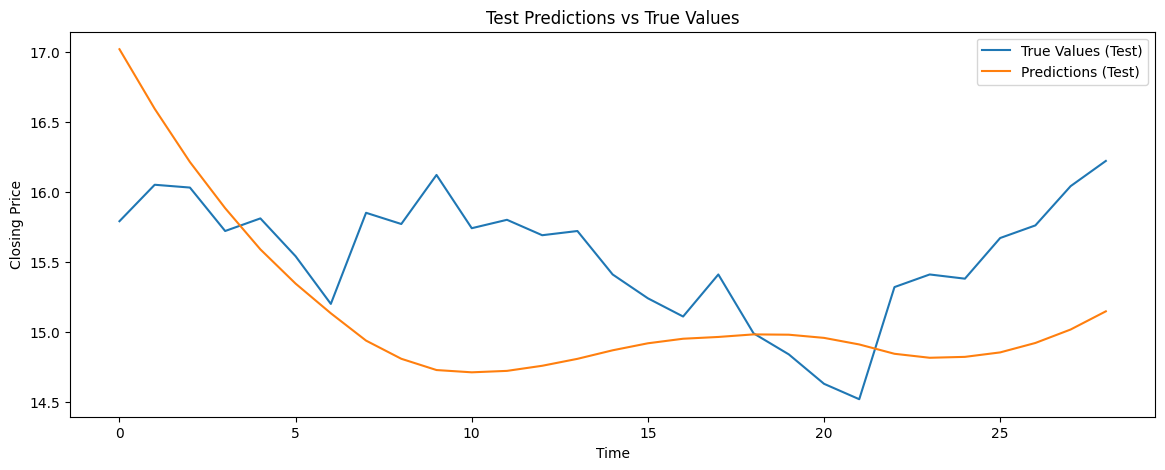

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# True values
y_val_true = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val_true, val_predictions)
val_mae = mean_absolute_error(y_val_true, val_predictions)
print(f'Validation MSE: {val_mse}')
print(f'Validation MAE: {val_mae}')

# Calculate metrics for test set
test_mse = mean_squared_error(y_test_true, test_predictions)
test_mae = mean_absolute_error(y_test_true, test_predictions)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')


# Plot validation predictions vs true values
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_val_true)), y_val_true, label='True Values (Validation)')
plt.plot(range(len(val_predictions)), val_predictions, label='Predictions (Validation)')
plt.title('Validation Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Plot test predictions vs true values
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test_true)), y_test_true, label='True Values (Test)')
plt.plot(range(len(test_predictions)), test_predictions, label='Predictions (Test)')
plt.title('Test Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



On seeing the graphs above, we can see we have a few issues with our current model :

**Overfitting:** <br>
The model seems to be overfitted to the validation data, as its performance deteriorates significantly on the test set.

**Lag**: <br>
There's a noticeable lag in predictions, suggesting the model might be relying too heavily on past data.

**Smoothing:** <br>
The model produces smoother predictions, missing short-term fluctuations in stock prices.

**Poor generalization:** <br>
The stark difference between validation and test performance indicates the model doesn't generalize well to new, unseen data.

**Trend misinterpretation:** <br>
Especially in the test set, the model fails to capture the actual trends in the stock prices.



### Improving Model Performance

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 755ms/step - loss: 0.1420 - val_loss: 0.0295
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0182 - val_loss: 0.0799
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0434 - val_loss: 0.0285
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - loss: 0.0117 - val_loss: 0.0409
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step - loss: 0.0199 - val_loss: 0.0357
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 0.0164 - val_loss: 0.0138
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0075 - val_loss: 0.0167
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0091 - val_loss: 0.0139
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0057 - val_l

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 885ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation MSE: 0.44484723794647074
Validation MAE: 0.5381509029504026
Test MSE: 0.27350584040077064
Test MAE: 0.39471272861256324


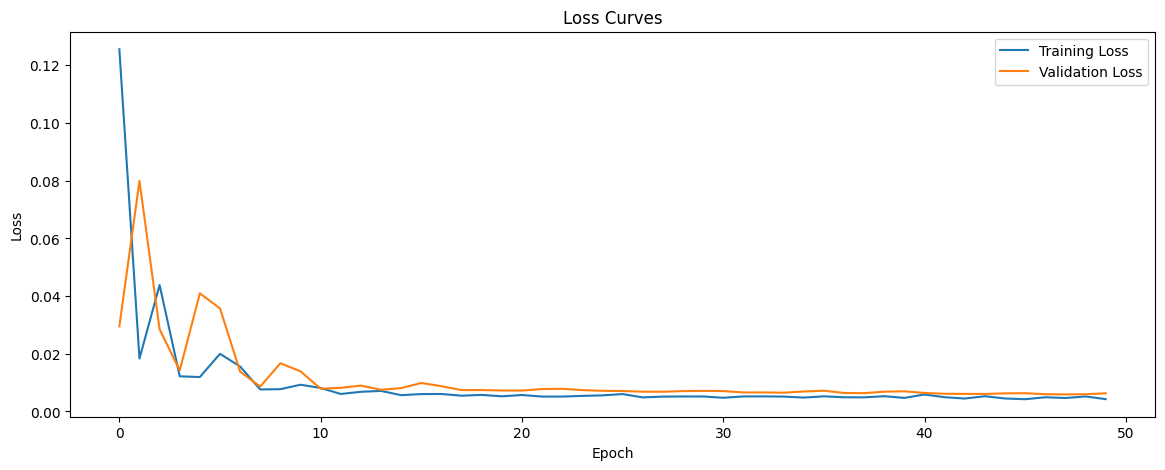

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam

# Define sequence length and number of features
sequence_length = 30
num_features = 1  # Adjust this based on the reshaped data

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(sequence_length, num_features)))  # Correct shape
model.add(Bidirectional(GRU(units=100, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(units=100, return_sequences=True)))
model.add(Dropout(0.3))
model.add(GRU(units=100))
model.add(Dense(units=1))

# Compile with a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,  # Adjusted batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
val_predictions = model.predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions)

test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

# Evaluate performance
val_mse = mean_squared_error(y_val_true, val_predictions)
val_mae = mean_absolute_error(y_val_true, val_predictions)
test_mse = mean_squared_error(y_test_true, test_predictions)
test_mae = mean_absolute_error(y_test_true, test_predictions)

print(f'Validation MSE: {val_mse}')
print(f'Validation MAE: {val_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')

# Plot loss curves
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


After retraining the model, we can see that the gap between the training loss and validation loss is closer, which means that our new approach did a good job of fitting the model 

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Reshape y_val and y_test to 2D
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Inverse transform predictions and true values
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_val_true = scaler.inverse_transform(y_val)
y_test_true = scaler.inverse_transform(y_test)

# Calculate performance metrics for validation set
val_mse = mean_squared_error(y_val_true, val_predictions)
val_mae = mean_absolute_error(y_val_true, val_predictions)
val_r2 = r2_score(y_val_true, val_predictions)

# Calculate performance metrics for test set
test_mse = mean_squared_error(y_test_true, test_predictions)
test_mae = mean_absolute_error(y_test_true, test_predictions)
test_r2 = r2_score(y_test_true, test_predictions)

print(f'Validation MSE: {val_mse}')
print(f'Validation MAE: {val_mae}')
print(f'Validation R^2: {val_r2}')

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R^2: {test_r2}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation MSE: 0.44484723794647074
Validation MAE: 0.5381509029504026
Validation R^2: 0.4676358564285992
Test MSE: 0.27350584040077064
Test MAE: 0.39471272861256324
Test R^2: 0.40563416336542224


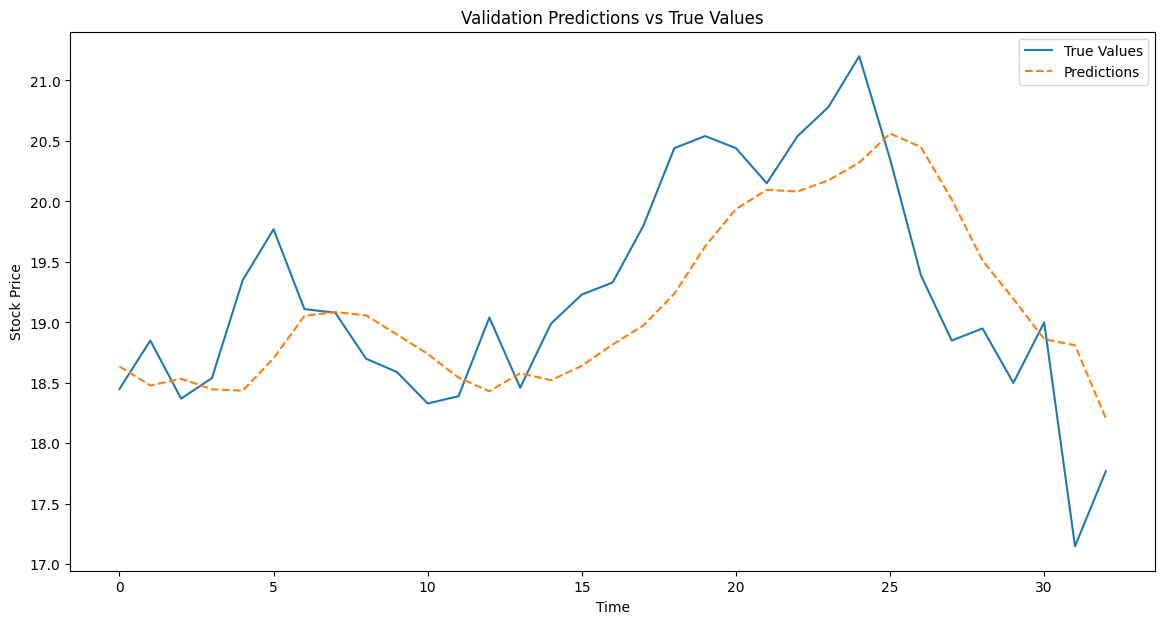

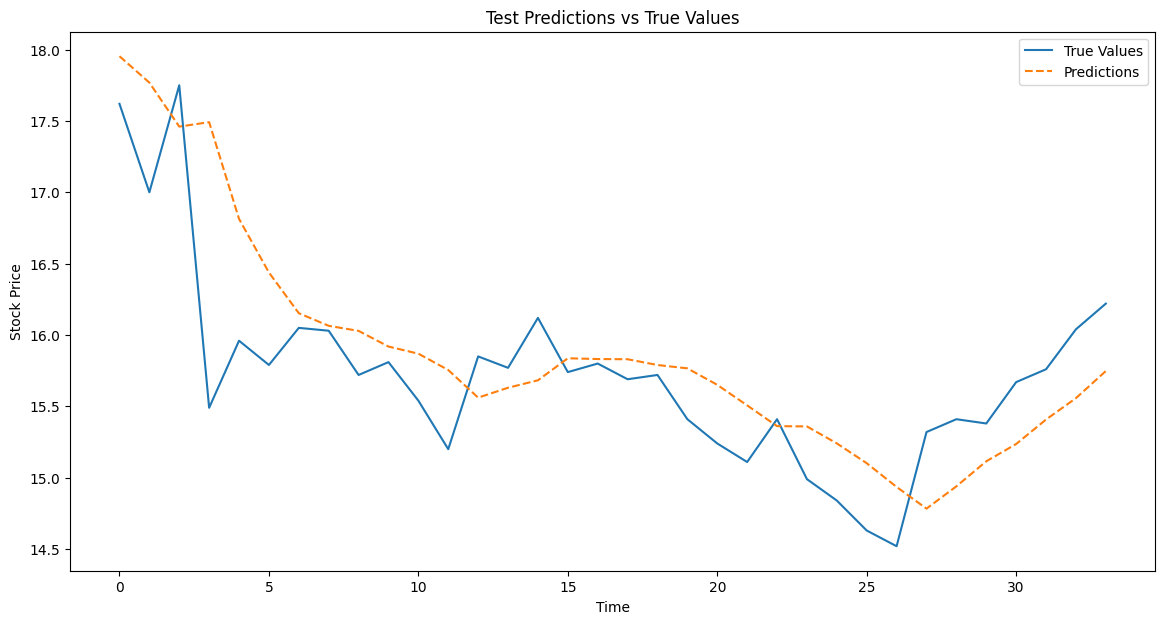

In [37]:
import matplotlib.pyplot as plt

# Plot validation predictions vs true values
plt.figure(figsize=(14, 7))
plt.plot(y_val_true, label='True Values')
plt.plot(val_predictions, label='Predictions', linestyle='--')
plt.title('Validation Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot test predictions vs true values
plt.figure(figsize=(14, 7))
plt.plot(y_test_true, label='True Values')
plt.plot(test_predictions, label='Predictions', linestyle='--')
plt.title('Test Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


As we can see from the graphs above, this time around, the predictions tend to be more similar to the actual values becuase of retraining the model. 

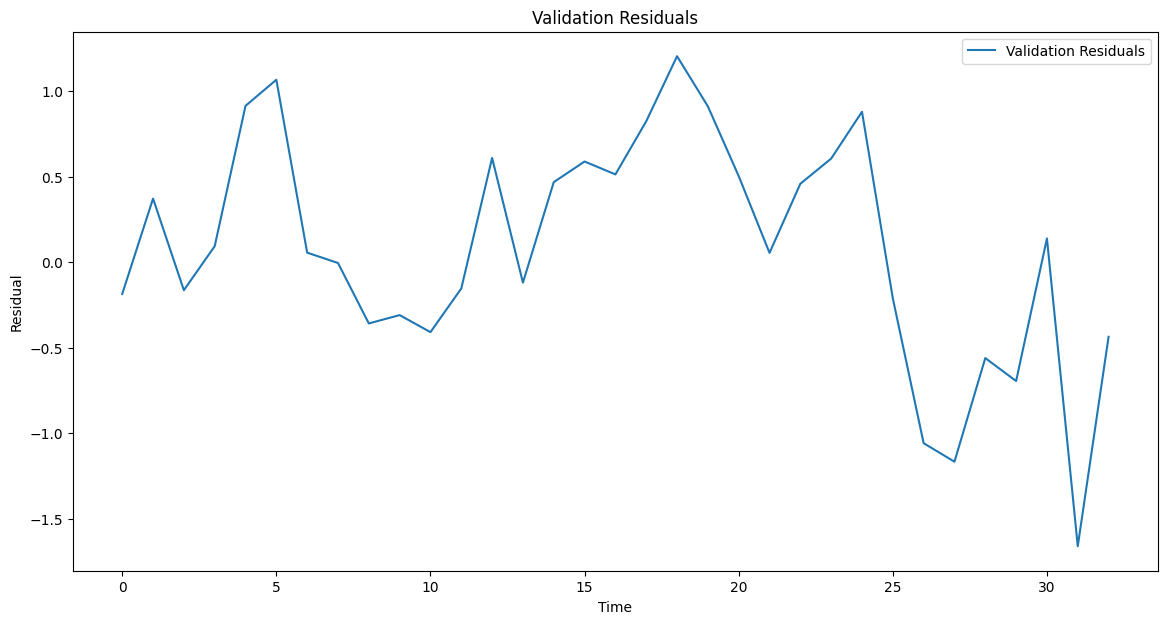

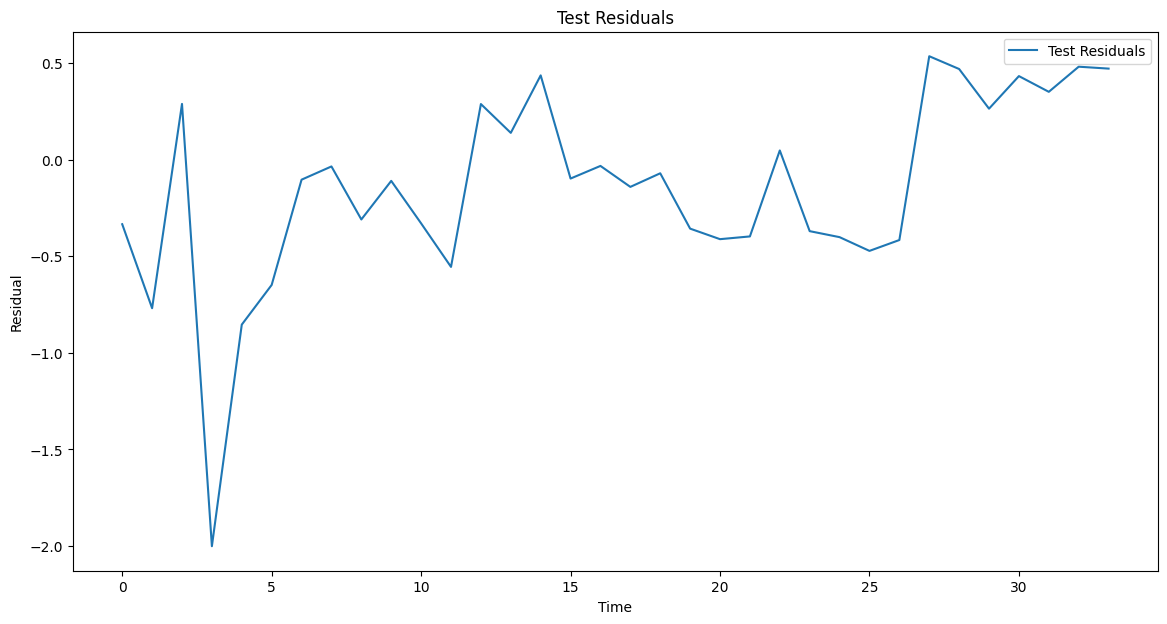

In [38]:
# Calculate residuals
val_residuals = y_val_true - val_predictions
test_residuals = y_test_true - test_predictions

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(val_residuals, label='Validation Residuals')
plt.title('Validation Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(test_residuals, label='Test Residuals')
plt.title('Test Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()


What can we infer from the graphs above ? 

**Validation Residuals:**

* Variability: The residuals for the validation set fluctuates around 0, which is expected in a well performing model 
* Patterns: There are visible patterns in the residuals which is because the model is not capturning some underlying structures in the data. 
* The residuals range around +-1.5 which means that the model's prediction can be off by a significant margin 

**Test Residuals:**

* Similar to the validation residuals, the test residuals also fluctuate a lot 
* The residuals in the test test have a broader range (between -2.0 to +1.0) meaning that the model's predictions are less accurate on the test data compared to the validation data 



## Current Problems

* Overfitting: 
The presence of patterns in both the validation and test residuals suggests that the model might be overfitting 

**Possible next step to address Overfitting: Regularization**
We could introduce dropout laters in the model to reduce overfitting. 

* Model Complexity: 
The LSTM actually might be too complex for the dataset in question. We could simplify the model or add regualarization techniques to reduce overfitting 

**Possible next step to address model complexity: Try and reduce the number of layers or units in the LSTM**

* Feature Engineering: 
Including more relevant features or techniques like feature selection could improve performance 

**Possible next step to address feature engineering:**
Revisit the features being used and see if any new features can be created or redundant ones be removed 

* Hyperparameter Tuning: 
Changing the hyperparameters such as the learning rate, batch size, number of laters, etc might yield better results. 

**Possible next step to address Hyperparamter Tuning:**
Conduct a grid search or use Bayesian Optimization to find better hyperparameters 

* Data Augmentation: 
The dataset is fairly small, so augmenting the data and using techniques like cross-validation could provide a more robust evaluation of the model

**Possible next step to address Data Augmentation:**
Imolement cross-validation to ensure the model's performance is consistent accross different subsets of data 

